<h2> Ten Year Risk of Developing Coronary Heart Disease 
    
    Notebook II:

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin

In [2]:
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier 
from sklearn.ensemble import AdaBoostClassifier 
from sklearn.ensemble import VotingClassifier 

from sklearn import svm
from sklearn.svm import SVR
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score

A quick refresher of how the data was prepared for our models in our second notebook:

In [3]:
df = pd.read_csv("C:/Users/apuk1/OneDrive/SCS 3253/Final/framingham.csv")

In [4]:
X = df.drop("TenYearCHD", axis = 1)
y = df["TenYearCHD"].copy()

In [5]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [6]:
print(X_train.shape)
print(X_test.shape)
print(f"Train with {X_train.shape[0]} samples and test with {X_test.shape[0]} samples.")

(3392, 15)
(848, 15)
Train with 3392 samples and test with 848 samples.


In [7]:
#Create a dataset with only numerical features and one with categorical features
df_num = X_train.drop(["male", "education", "currentSmoker", "BPMeds", "prevalentStroke", "prevalentHyp", "diabetes"], axis=1)

num_attribs = list(df_num) 
cat_attribs = ["male", "education", "currentSmoker", "BPMeds", "prevalentStroke", "prevalentHyp", "diabetes"]

num_pipeline = Pipeline([('Imputer', SimpleImputer(strategy="median")),('StandardScaler', StandardScaler()),])
cat_pipeline = Pipeline([('Imputer', SimpleImputer(strategy="most_frequent")), ('OneHotEncoder', OneHotEncoder()),])

In [8]:
#Final and prepared datasets ready for modeling:
full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", cat_pipeline, cat_attribs),])

In [9]:
X_train = full_pipeline.fit_transform(X_train)
print(X_train.shape)

X_test = full_pipeline.transform(X_test)
print(X_test.shape)

(3392, 24)
(848, 24)


Our second data set where we randomly oversampled the marginalized class to see how this affects the performance of our models:

In [10]:
# Class count
count_class_0, count_class_1 = df.TenYearCHD.value_counts()
print(count_class_0, count_class_1)

# Divide by class
df_class_0 = df[df['TenYearCHD'] == 0]
df_class_1 = df[df['TenYearCHD'] == 1]

3596 644


Random over-sampling:
1    3596
0    3596
Name: TenYearCHD, dtype: int64


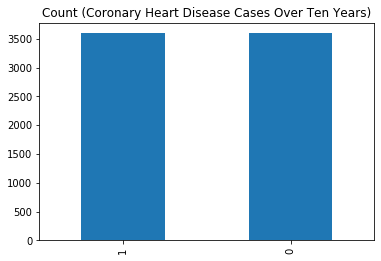

In [11]:
df_class_1_over = df_class_1.sample(count_class_0, replace=True)
df_over = pd.concat([df_class_0, df_class_1_over], axis=0)

print('Random over-sampling:')
print(df_over.TenYearCHD.value_counts())

df_over.TenYearCHD.value_counts().plot(kind='bar', title='Count (Coronary Heart Disease Cases Over Ten Years)')

In [12]:
X_over = df_over.drop("TenYearCHD", axis = 1)
y_over = df_over["TenYearCHD"].copy()
X_over.shape

(7192, 15)

In [13]:
# Split the data
X_train_over, X_test_over, y_train_over, y_test_over = train_test_split(X_over, y_over, test_size=0.2)

In [14]:
print(X_train_over.shape)
print(X_test_over.shape)
print(f"Train with {X_train_over.shape[0]} samples and test with {X_test_over.shape[0]} samples.")

(5753, 15)
(1439, 15)
Train with 5753 samples and test with 1439 samples.


In [15]:
#Create a dataset with only numerical features and one with categorical features
df_num_over = X_train_over.drop(["male", "education", "currentSmoker", "BPMeds", "prevalentStroke", "prevalentHyp", "diabetes"], axis=1)

num_attribs_over = list(df_num_over) 
cat_attribs_over = ["male", "education", "currentSmoker", "BPMeds", "prevalentStroke", "prevalentHyp", "diabetes"]

num_pipeline_over = Pipeline([('Imputer', SimpleImputer(strategy="median")),('StandardScaler', StandardScaler()),])
cat_pipeline_over = Pipeline([('Imputer', SimpleImputer(strategy="most_frequent")), ('OneHotEncoder', OneHotEncoder()),])

In [16]:
#Final and prepared datasets ready for modeling:
full_pipeline_over = ColumnTransformer([
        ("num", num_pipeline_over, num_attribs_over),
        ("cat", cat_pipeline_over, cat_attribs_over),])

In [17]:
X_train_over = full_pipeline_over.fit_transform(X_train_over)
print(X_train_over.shape)

X_test_over = full_pipeline_over.transform(X_test_over)
print(X_test_over.shape)

(5753, 24)
(1439, 24)


<h3> Part I: Models <h3>

For our dataset, we will be using the following classification models and determine which model makes the best predictions:
- K-Nearest Neighbours Classification
- Logistic Regression Classification
- Decision Tree Classification
- Random Forest Classification
- Ensemble Learning Methods (Hard Voting and Stacking)

For each of these models, we will build the model and test out how the base model performs on the training set, tune it, and then examine the performance of the model on the testing set for both of our datasets: the unbalanced dataset represented as X_train, and the balanced dataset (balanced by oversampling the class in which CHD is positive) X_train_over.

Lastly, we will compare our models by examining their calssification reports along with direct comparison of their ROC curves.

<h3> A. K-Nearest Neighbour Classification <h3>

<h4> Build the Model <h4>

In [18]:
KNN = KNeighborsClassifier()
KNN.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

Accuracy of K-Nearest Neighbour Classifier on test set: 0.86
              precision    recall  f1-score   support

           0       0.87      0.98      0.92      2878
           1       0.67      0.20      0.31       514

    accuracy                           0.86      3392
   macro avg       0.77      0.59      0.62      3392
weighted avg       0.84      0.86      0.83      3392



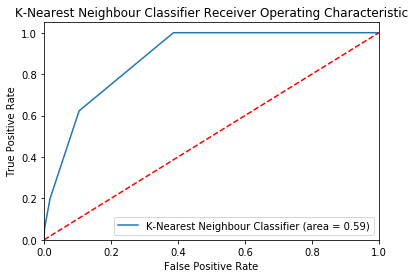

In [19]:
#test the general performance of our model using X_train (i.e. our unbalanced dataset):
y_pred_knn = KNN.predict(X_train)

print('Accuracy of K-Nearest Neighbour Classifier on test set: {:.2f}'.format(KNN.score(X_train, y_train)))
print(classification_report(y_train, y_pred_knn))

logit_roc_auc = roc_auc_score(y_train, KNN.predict(X_train))
fpr, tpr, thresholds = roc_curve(y_train, KNN.predict_proba(X_train)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='K-Nearest Neighbour Classifier (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('K-Nearest Neighbour Classifier Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig('KNN_ROC')
plt.show()

<h4> Tune the Model <h4>

In [20]:
#tune our model with the n_neighbours hyperparameter to improve the low recall score for class 1 (i.e. presence of CHD)
# we want to score based on the auc score, since we want our model to be able to predict the presence of disease or no disease
#accurately
param_grid = [{'n_neighbors':  [15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]}]

grid_search_KNN = GridSearchCV(KNeighborsClassifier(), param_grid, cv=4, scoring='roc_auc')
grid_search_KNN.fit(X_train, y_train)

GridSearchCV(cv=4, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid=[{'n_neighbors': [15, 16, 17, 18, 19, 20, 21, 22, 23,
                                          24, 25]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', verbose=0)

In [21]:
grid_search_KNN.best_params_

{'n_neighbors': 24}

In [22]:
cvres_KNN = grid_search_KNN.cv_results_
for mean_score, params in zip(cvres_KNN["mean_test_score"], cvres_KNN["params"]):
    print(mean_score, params)

0.6625264506076753 {'n_neighbors': 15}
0.6665630602934032 {'n_neighbors': 16}
0.6677210650090138 {'n_neighbors': 17}
0.6698786189243692 {'n_neighbors': 18}
0.6721095608958365 {'n_neighbors': 19}
0.6738732806139865 {'n_neighbors': 20}
0.6732451762052825 {'n_neighbors': 21}
0.6744258617571902 {'n_neighbors': 22}
0.6778876046028424 {'n_neighbors': 23}
0.6796679947562897 {'n_neighbors': 24}
0.678545866085816 {'n_neighbors': 25}


In [23]:
#Create our final knn_model with the best hyperparameter- to be used for making predictions for our test data
best_KNN_model=KNN = KNeighborsClassifier(n_neighbors= 24)

<h4> Predict <h4>

In [24]:
#Fit our model on the unbalanced dataset first:
best_KNN_model.fit(X_train, y_train)

print ('K-Nearest Neighbour: TRAINING', best_KNN_model.score(X_train,y_train))

K-Nearest Neighbour: TRAINING 0.8522995283018868


In [25]:
#Use cross validation scoring to see the performance on our data:
cross_val_score(best_KNN_model, X_train, y_train, cv=4)

array([0.85023585, 0.85023585, 0.84787736, 0.85023585])

Accuracy of K-Nearest Neighbour on test set: 0.85
              precision    recall  f1-score   support

           0       0.85      0.99      0.92       718
           1       0.43      0.02      0.04       130

    accuracy                           0.85       848
   macro avg       0.64      0.51      0.48       848
weighted avg       0.78      0.85      0.78       848



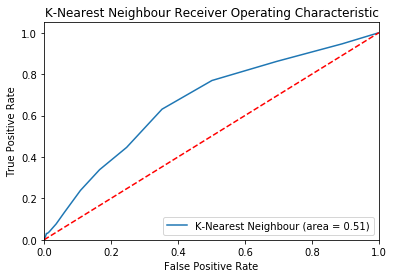

In [26]:
#Make predictions on our unbalanced data set:
y_pred_knn = best_KNN_model.predict(X_test)

print('Accuracy of K-Nearest Neighbour on test set: {:.2f}'.format(best_KNN_model.score(X_test, y_test)))
print(classification_report(y_test, y_pred_knn))

logit_roc_auc = roc_auc_score(y_test, best_KNN_model.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, best_KNN_model.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='K-Nearest Neighbour (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('K-Nearest Neighbour Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig('KNN_ROC')
plt.show()

Next, we take a look at the oversampled balanced dataset to see if we can get better results for recall in positive CHD cases:

In [27]:
best_KNN_model.fit(X_train_over, y_train_over)
print ('K-Nearest Neighbour: TRAINING', best_KNN_model.score(X_train_over,y_train_over))

K-Nearest Neighbour: TRAINING 0.7338779767078046


In [28]:
cross_val_score(best_KNN_model, X_train_over, y_train_over, cv=4)

array([0.66990966, 0.68150209, 0.69471488, 0.68358832])

Accuracy of K-Nearest Neighbour on test set: 0.69
              precision    recall  f1-score   support

           0       0.73      0.67      0.70       752
           1       0.67      0.73      0.69       687

    accuracy                           0.69      1439
   macro avg       0.70      0.70      0.69      1439
weighted avg       0.70      0.69      0.69      1439



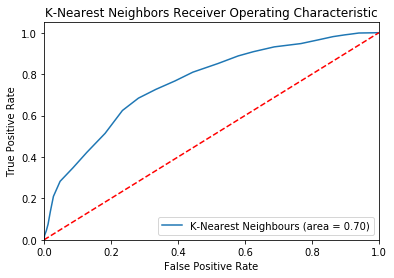

In [29]:
y_pred_knn = best_KNN_model.predict(X_test_over)

print('Accuracy of K-Nearest Neighbour on test set: {:.2f}'.format(best_KNN_model.score(X_test_over, y_test_over)))
print(classification_report(y_test_over, y_pred_knn))

logit_roc_auc = roc_auc_score(y_test_over, best_KNN_model.predict(X_test_over))
fpr, tpr, thresholds = roc_curve(y_test_over, best_KNN_model.predict_proba(X_test_over)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='K-Nearest Neighbours (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('K-Nearest Neighbors Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig('KNN_ROC')
plt.show()

With the balanced dataset, some metrics for class 0 goes down, but the f1 scores for both classes level off and recall for predicting positive CHD cases increases.

<h3> B. Logistic Regression: <h3>

In [30]:
logreg = LogisticRegression(random_state=123)
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=123, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Accuracy of logistic regression classifier on test set: 0.86
              precision    recall  f1-score   support

           0       0.86      0.99      0.92      2878
           1       0.74      0.09      0.16       514

    accuracy                           0.86      3392
   macro avg       0.80      0.54      0.54      3392
weighted avg       0.84      0.86      0.81      3392



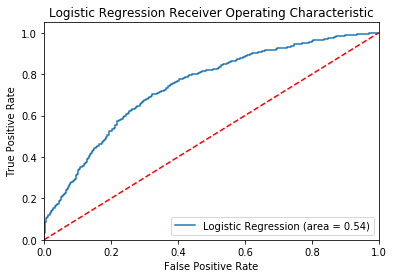

In [31]:
#Test the general performance of our model using X_train (i.e. our unbalanced dataset):
y_pred = logreg.predict(X_train)

print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_train, y_train)))
print(classification_report(y_train, y_pred))

logit_roc_auc = roc_auc_score(y_train, logreg.predict(X_train))
fpr, tpr, thresholds = roc_curve(y_train, logreg.predict_proba(X_train)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

<h4> Tune: <h4>

In [32]:
#tune our model with the 'C' hyperparameter

param_grid = {'C': [0.001, 0.01, 0.05, 0.1, 0.15, 0.2, 0.3, 0.35, 0.8]}

grid_search_log= GridSearchCV(logreg, param_grid, cv=4, scoring='roc_auc')
grid_search_log.fit(X_train, y_train)

print(grid_search_log.best_params_)
print(grid_search_log.best_score_) 

{'C': 0.05}
0.734833583365734


In [33]:
#Create our final logistic model with the best hyperparameter- to be used for making predictions for our test data
best_logistic_model=LogisticRegression(C=0.05, random_state=123)

<h4> Predict: <h4>

In [34]:
#Fit our model on the unbalanced dataset first:
best_logistic_model.fit(X_train, y_train)

print ('Logistic Regression Classification Accuracy: TRAINING', best_logistic_model.score(X_train,y_train))

Logistic Regression Classification Accuracy: TRAINING 0.8564268867924528


In [35]:
#Use cross validation scoring to see the performance on our data:
cross_val_score(best_logistic_model, X_train, y_train, cv=4)

array([0.85495283, 0.85495283, 0.85731132, 0.85613208])

Accuracy of logistic regression classifier on test set: 0.85
              precision    recall  f1-score   support

           0       0.85      1.00      0.92       718
           1       0.67      0.05      0.09       130

    accuracy                           0.85       848
   macro avg       0.76      0.52      0.50       848
weighted avg       0.82      0.85      0.79       848



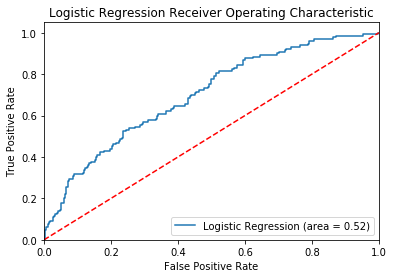

In [36]:
#Make predictions on our unbalanced data set:
best_logistic_model.fit(X_train, y_train)
y_pred = best_logistic_model.predict(X_test)

print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(best_logistic_model.score(X_test, y_test)))
print(classification_report(y_test, y_pred))

logit_roc_auc = roc_auc_score(y_test, best_logistic_model.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, best_logistic_model.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

Next, we take a look at the oversampled balanced dataset to see if we can get better results for positive CHD cases:

Accuracy of logistic regression classifier on test set: 0.67
              precision    recall  f1-score   support

           0       0.69      0.66      0.68       752
           1       0.65      0.67      0.66       687

    accuracy                           0.67      1439
   macro avg       0.67      0.67      0.67      1439
weighted avg       0.67      0.67      0.67      1439



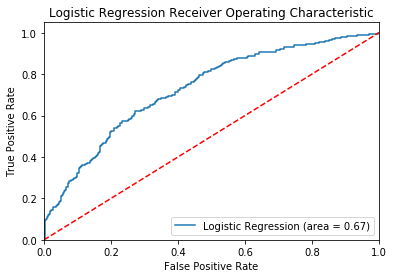

In [37]:
best_logistic_model.fit(X_train_over, y_train_over)

y_pred_over = best_logistic_model.predict(X_test_over)

print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(best_logistic_model.score(X_test_over, y_test_over)))
print(classification_report(y_test_over, y_pred_over))

logit_roc_auc = roc_auc_score(y_test_over, best_logistic_model.predict(X_test_over))
fpr, tpr, thresholds = roc_curve(y_test_over, best_logistic_model.predict_proba(X_test_over)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In looking at the results and in comparing accuracy, precision, recall and auc scores, we can see that with regards to accuracy, accuracy is much higher at 85% with balanced classes, and drops down to 67% with balanced classes. In the unbalanced data set, precision and recall are fairly accurate in predicting that an individual is not prone to developing coronary heart disease based on their current health and lifestyle, but poor at detecting the positive coronary heart disease cases. This may be due to not enough training data and having unbalanced classes. With the balanced dataset, precision and recall decrease in non-CHD cases, though becomes more accurate in terms of precision and recall for detecting cases of CHD. In this case, having a higher recall is more valuable, since we want to be able to accurately whether someone will develop coronary heart disease over a ten year span as opposed to predicting that they won't.

<h3> C. Decision Tree Classification <h3>

<h4> Build the Model <h4>

In [38]:
tree_clf = DecisionTreeClassifier(random_state=123)
tree_clf.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=123, splitter='best')

Accuracy of Decision Tree Classifier on test set: 1.00
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2878
           1       1.00      1.00      1.00       514

    accuracy                           1.00      3392
   macro avg       1.00      1.00      1.00      3392
weighted avg       1.00      1.00      1.00      3392



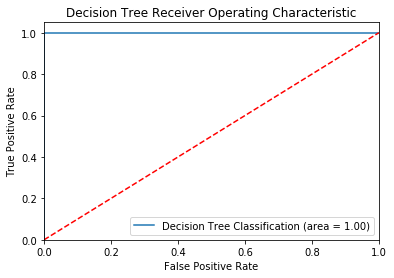

In [39]:
#Test the general performance of our model using X_train (i.e. our unbalanced dataset):
y_pred_tree = tree_clf.predict(X_train)

print('Accuracy of Decision Tree Classifier on test set: {:.2f}'.format(tree_clf.score(X_train, y_train)))
print(classification_report(y_train, y_pred_tree))
logit_roc_auc = roc_auc_score(y_train, tree_clf.predict(X_train))
fpr, tpr, thresholds = roc_curve(y_train, tree_clf.predict_proba(X_train)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Decision Tree Classification (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Decision Tree Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

Based on the classification report and the ROC curve, this model is overfitting on the training set and requires tuning.

<h4> Tune the Model <h4>

To help us see what good values are for our hyperparameters, we plot the following:

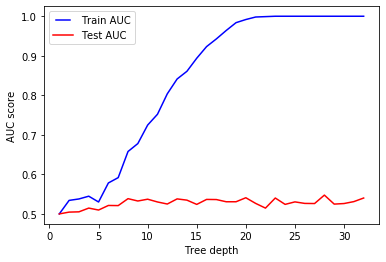

In [40]:
#max-depth:
from sklearn.metrics import auc
max_depths = np.linspace(1, 32, 32, endpoint=True)
train_results = []
test_results = []
for max_depth in max_depths:
   dt = DecisionTreeClassifier(max_depth=max_depth)
   dt.fit(X_train, y_train)
   train_pred = dt.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   # Add auc score to previous train results
   train_results.append(roc_auc)
   y_pred = dt.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   # Add auc score to previous test results
   test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, train_results, 'b', label="Train AUC")
line2, = plt.plot(max_depths, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("AUC score")
plt.xlabel("Tree depth")
plt.show()

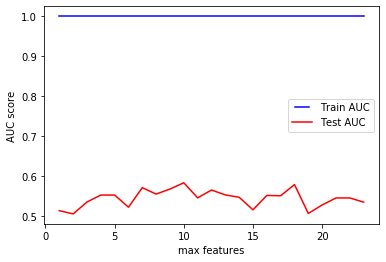

In [41]:
#max_features
max_features = list(range(1,X_train.shape[1]))
train_results = []
test_results = []
for max_feature in max_features:
   dt = DecisionTreeClassifier(max_features=max_feature)
   dt.fit(X_train, y_train)
   train_pred = dt.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = dt.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_features, train_results, 'b', label="Train AUC")
line2, = plt.plot(max_features, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("AUC score")
plt.xlabel("max features")
plt.show()

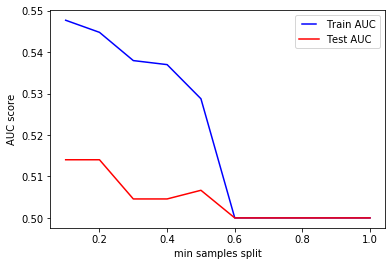

In [42]:
#min_samples_split:
min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)
train_results = []
test_results = []
for min_samples_split in min_samples_splits:
   dt = DecisionTreeClassifier(min_samples_split=min_samples_split)
   dt.fit(X_train, y_train)
   train_pred = dt.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds =roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = dt.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(min_samples_splits, train_results, 'b', label="Train AUC")
line2, = plt.plot(min_samples_splits, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("AUC score")
plt.xlabel("min samples split")
plt.show()

We can also test these values using GridSearch:

In [43]:
#Tune our model with the max_features, max_depth and min_samples_split hyperparameter to improve our model and guage generally
#where the best value lies to integrate it in one gridsearch afterwards

param_grid = [{'max_features': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 20]}] 

grid_search_tree_clf = GridSearchCV(tree_clf, param_grid, cv=4 ,scoring='roc_auc')
grid_search_tree_clf.fit(X_train, y_train)
grid_search_tree_clf.best_params_

{'max_features': 15}

In [44]:
param_grid = [{'max_depth': [1, 2, 3, 4, 10, 15, 19, 20, 21, 22, 23, 24, 25]}] 

grid_search_tree_clf = GridSearchCV(tree_clf, param_grid, cv=4 ,scoring='roc_auc')
grid_search_tree_clf.fit(X_train, y_train)
grid_search_tree_clf.best_params_

{'max_depth': 4}

In [45]:
param_grid = [{'min_samples_split':  [100, 200, 300, 1000, 1100, 1150, 1200, 1250, 1300, 1310, 1350, 1400, 1500, 2000, 2500]}] 

grid_search_tree_clf = GridSearchCV(tree_clf, param_grid, cv=4 ,scoring='roc_auc')
grid_search_tree_clf.fit(X_train, y_train)
grid_search_tree_clf.best_params_

{'min_samples_split': 300}

After getting a sense of the range where the best values lie, we can test all the hyperparameters together:

In [46]:
param_grid = [{'max_features': [2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20], 'max_depth': [1, 2, 5, 6, 7, 8, 9, 10], 'min_samples_split': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1200, 1250, 1300], 'criterion': ['gini', 'entropy']}] 

grid_search_tree_clf = GridSearchCV(tree_clf, param_grid, cv=4 ,scoring='roc_auc')
grid_search_tree_clf.fit(X_train, y_train)
grid_search_tree_clf.best_params_

{'criterion': 'gini',
 'max_depth': 9,
 'max_features': 15,
 'min_samples_split': 200}

In [47]:
#Create our final tree model with the best hyperparameter- to be used for making predictions for our test data
best_tree_model=DecisionTreeClassifier(max_features=15, max_depth=9, min_samples_split=200, criterion='gini', random_state = 123)

<h4> Predict <h4>

In [48]:
#Fit our model on the unbalanced dataset first:
best_tree_model.fit(X_train, y_train)

print ('Decision Tree Classification Accuracy: TRAINING', best_tree_model.score(X_train,y_train))

Decision Tree Classification Accuracy: TRAINING 0.8573113207547169


In [49]:
#Use cross validation scoring to see the performance on our data:
cross_val_score(best_tree_model, X_train, y_train, cv=4)

array([0.85023585, 0.84669811, 0.84433962, 0.84787736])

Accuracy of Decision Tree Classifier on test set: 0.84
              precision    recall  f1-score   support

           0       0.85      0.98      0.91       718
           1       0.30      0.05      0.08       130

    accuracy                           0.84       848
   macro avg       0.58      0.51      0.50       848
weighted avg       0.77      0.84      0.78       848



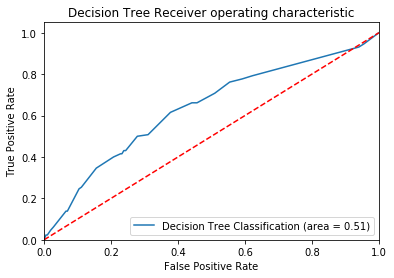

In [50]:
#Make predictions on our unbalanced data set:
y_pred_tree = best_tree_model.predict(X_test)

print('Accuracy of Decision Tree Classifier on test set: {:.2f}'.format(best_tree_model.score(X_test, y_test)))
print(classification_report(y_test, y_pred_tree))

logit_roc_auc = roc_auc_score(y_test, best_tree_model.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, best_tree_model.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Decision Tree Classification (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Decision Tree Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

Next, we take a look at the oversampled balanced dataset to see if we can get better results for positive CHD cases:

In [51]:
best_tree_model.fit(X_train_over, y_train_over)
print ('Decision Tree Accuracy: TRAINING', best_tree_model.score(X_train_over,y_train_over))

Decision Tree Accuracy: TRAINING 0.7277941943333913


In [52]:
cross_val_score(best_tree_model, X_train_over, y_train_over, cv=4)

array([0.69284225, 0.69193324, 0.69819193, 0.71070932])

Accuracy of Decision Tree Classifier on test set: 0.68
              precision    recall  f1-score   support

           0       0.73      0.60      0.66       752
           1       0.64      0.76      0.69       687

    accuracy                           0.68      1439
   macro avg       0.69      0.68      0.68      1439
weighted avg       0.69      0.68      0.68      1439



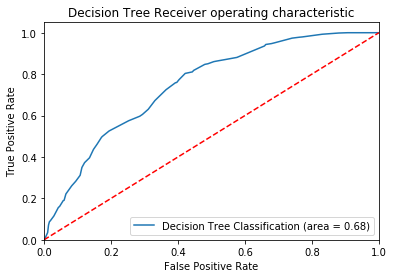

In [53]:
y_pred_tree = best_tree_model.predict(X_test_over)

print('Accuracy of Decision Tree Classifier on test set: {:.2f}'.format(best_tree_model.score(X_test_over, y_test_over)))
print(classification_report(y_test_over, y_pred_tree))

logit_roc_auc = roc_auc_score(y_test_over, best_tree_model.predict(X_test_over))
fpr, tpr, thresholds = roc_curve(y_test_over, best_tree_model.predict_proba(X_test_over)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Decision Tree Classification (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Decision Tree Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Tree_ROC')
plt.show()

Next, in comparison with using boosting (i.e. using AdaBoost), we can see if the Decision Tree Classification model can be improved:

In [54]:
ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_features=15, max_depth=9, min_samples_split=200, criterion='gini', random_state = 123), n_estimators = 200, algorithm ="SAMME.R", learning_rate = 0.5) 
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=9,
                                                         max_features=15,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=200,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                          

Accuracy of Decision Tree Classifier with Ada Boost on test set: 0.80
              precision    recall  f1-score   support

           0       0.85      0.93      0.89       718
           1       0.20      0.10      0.13       130

    accuracy                           0.80       848
   macro avg       0.52      0.51      0.51       848
weighted avg       0.75      0.80      0.77       848



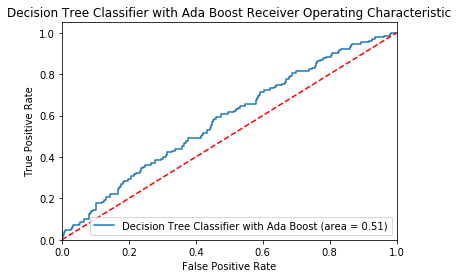

In [55]:
y_pred = ada_clf.predict(X_test)

print('Accuracy of Decision Tree Classifier with Ada Boost on test set: {:.2f}'.format(ada_clf.score(X_test, y_test)))
print(classification_report(y_test, y_pred))

logit_roc_auc = roc_auc_score(y_test, ada_clf.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, ada_clf.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Decision Tree Classifier with Ada Boost (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Decision Tree Classifier with Ada Boost Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig('Ada_ROC')
plt.show()

In [56]:
ada_clf.fit(X_train_over, y_train_over)
y_pred_over = ada_clf.predict(X_test_over)

Accuracy of Decision Tree Classifier with Ada Boost on test set: 0.93
              precision    recall  f1-score   support

           0       0.99      0.88      0.93       752
           1       0.88      0.99      0.93       687

    accuracy                           0.93      1439
   macro avg       0.94      0.94      0.93      1439
weighted avg       0.94      0.93      0.93      1439



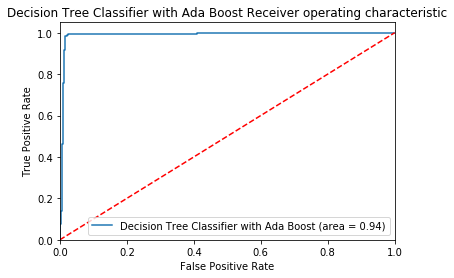

In [57]:
print('Accuracy of Decision Tree Classifier with Ada Boost on test set: {:.2f}'.format(ada_clf.score(X_test_over, y_test_over)))
print(classification_report(y_test_over, y_pred_over))

logit_roc_auc = roc_auc_score(y_test_over, ada_clf.predict(X_test_over))
fpr, tpr, thresholds = roc_curve(y_test_over, ada_clf.predict_proba(X_test_over)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Decision Tree Classifier with Ada Boost (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Decision Tree Classifier with Ada Boost Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Ada_ROC')
plt.show()

AdaBoost significantly improved both recall and precision, especially with the balanced data set.

<h3> D. Random Forest <h3>

<h4> Model <h4>

In [58]:
forest_clf = RandomForestClassifier(random_state = 123) 
forest_clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=123,
                       verbose=0, warm_start=False)

Accuracy of Random Forest on train set: 1.00
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2878
           1       1.00      1.00      1.00       514

    accuracy                           1.00      3392
   macro avg       1.00      1.00      1.00      3392
weighted avg       1.00      1.00      1.00      3392



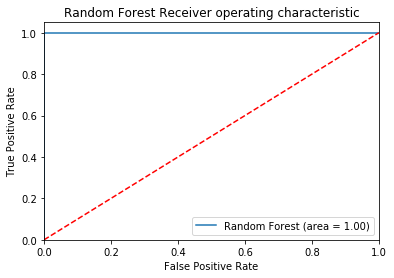

In [59]:
#Test the general performance of our model using X_train (i.e. our unbalanced dataset):

y_pred_forest = forest_clf.predict(X_train)

print('Accuracy of Random Forest on train set: {:.2f}'.format(forest_clf.score(X_train, y_train)))
print(classification_report(y_train, y_pred_forest))

logit_roc_auc = roc_auc_score(y_train, forest_clf.predict(X_train))
fpr, tpr, thresholds = roc_curve(y_train, forest_clf.predict_proba(X_train)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Random Forest (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('RF_ROC')
plt.show()

<h4> Model Tuning <h4>

Tune the model using the same process as used in Decision Tree Classification:

In [73]:
param_grid = [{'n_estimators':  [300, 305, 308, 309, 310, 311, 315, 320, 330]}] 

grid_search_forest_clf = GridSearchCV(forest_clf, param_grid, cv=4 ,scoring='accuracy')
grid_search_forest_clf.fit(X_train, y_train)
grid_search_forest_clf.best_params_

{'n_estimators': 308}

In [74]:
param_grid = [{'max_features': [1, 2, 3, 4, 10, 20]}] 

grid_search_forest_clf = GridSearchCV(forest_clf, param_grid, cv=4 ,scoring='accuracy')
grid_search_forest_clf.fit(X_train, y_train)
grid_search_forest_clf.best_params_

{'max_features': 4}

In [75]:
param_grid = [{'max_depth': [2, 3, 4, 10, 15, 19, 20, 21, 22, 23, 24, 25]}] 

grid_search_forest_clf = GridSearchCV(forest_clf, param_grid, cv=4 ,scoring='accuracy')
grid_search_forest_clf.fit(X_train, y_train)
grid_search_forest_clf.best_params_

{'max_depth': 22}

In [76]:
param_grid = [{'min_samples_split':  [5, 10, 15, 18, 19, 20, 21, 22, 25, 100]}] 

grid_search_forest_clf = GridSearchCV(forest_clf, param_grid, cv=4 ,scoring='accuracy')
grid_search_forest_clf.fit(X_train, y_train)
grid_search_forest_clf.best_params_

{'min_samples_split': 25}

After getting a sense of where the best values may lie, we put it in one GridSearch:

In [77]:
param_grid = [{'n_estimators':  [200, 300, 305, 310, 315],'max_features': [3, 4, 5], 'max_depth': [10, 15, 20], 'min_samples_split': [15, 20, 25], 'criterion': ['gini', 'entropy']}] 

grid_search_forest_clf = GridSearchCV(forest_clf, param_grid, cv=4 ,scoring='accuracy')
grid_search_forest_clf.fit(X_train, y_train)
grid_search_forest_clf.best_params_

{'criterion': 'gini',
 'max_depth': 20,
 'max_features': 5,
 'min_samples_split': 15,
 'n_estimators': 200}

In [78]:
#Create our final forest model with the best hyperparameter- to be used for making predictions for our test data
best_forest_model=RandomForestClassifier(n_estimators=200, max_features=5, max_depth=20, min_samples_split=15, criterion='gini', random_state = 123)

<h4> Predictions <h4>

In [79]:
#Fit our model on the unbalanced dataset first:
best_forest_model.fit(X_train, y_train)

print ('Random Forest Accuracy: TRAINING', best_forest_model.score(X_train,y_train))

Random Forest Accuracy: TRAINING 0.8918042452830188


In [80]:
#Use cross validation scoring to see the performance on our data:
cross_val_score(best_forest_model, X_train, y_train, cv=4)

array([0.85849057, 0.85613208, 0.85023585, 0.84787736])

Accuracy of Random Forest Classifier on test set: 0.85
              precision    recall  f1-score   support

           0       0.86      0.99      0.92       718
           1       0.67      0.08      0.14       130

    accuracy                           0.85       848
   macro avg       0.76      0.53      0.53       848
weighted avg       0.83      0.85      0.80       848



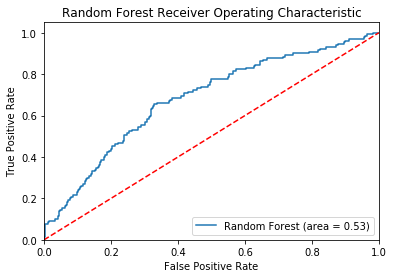

In [81]:
#Make predictions on our unbalanced data set:
y_pred_forest = best_forest_model.predict(X_test)

print('Accuracy of Random Forest Classifier on test set: {:.2f}'.format(best_forest_model.score(X_test, y_test)))
print(classification_report(y_test, y_pred_forest))

logit_roc_auc = roc_auc_score(y_test, best_forest_model.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, best_forest_model.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Random Forest (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig('RF_ROC')
plt.show()

Next, we take a look at the oversampled balanced dataset to see if we can get better results for positive CHD cases:

In [82]:
best_forest_model.fit(X_train_over, y_train_over)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features=5,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=15,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=123,
                       verbose=0, warm_start=False)

In [83]:
cross_val_score(best_forest_model, X_train_over, y_train_over, cv=4)

array([0.8714385 , 0.89082058, 0.90333797, 0.90333797])

Accuracy of Random Forest on test set: 0.93
              precision    recall  f1-score   support

           0       0.97      0.90      0.93       752
           1       0.90      0.97      0.93       687

    accuracy                           0.93      1439
   macro avg       0.93      0.93      0.93      1439
weighted avg       0.93      0.93      0.93      1439



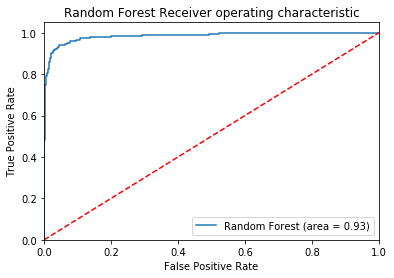

In [84]:
y_pred_forest = best_forest_model.predict(X_test_over)

print('Accuracy of Random Forest on test set: {:.2f}'.format(best_forest_model.score(X_test_over, y_test_over)))
print(classification_report(y_test_over, y_pred_forest))

logit_roc_auc = roc_auc_score(y_test_over, best_forest_model.predict(X_test_over))
fpr, tpr, thresholds = roc_curve(y_test_over, best_forest_model.predict_proba(X_test_over)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Random Forest (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('RF_ROC')
plt.show()

<h3> E. Ensemble Learning: Voting and Stacking <h3>

<h4> Hard Voting <h4>

In [85]:
voting_clf = VotingClassifier(estimators =[('knn', best_KNN_model), ('lr', best_logistic_model), ('tr', best_tree_model), ('ada', ada_clf), ('rf', best_forest_model)], voting ='hard') 
voting_clf.fit(X_train, y_train) 

#Let’s look at each classifier’s accuracy on the test set: 
for clf in (best_KNN_model, best_logistic_model, best_tree_model, ada_clf, best_forest_model, voting_clf): 
    clf.fit(X_train, y_train) 
    y_pred = clf.predict(X_test) 
    print("train:",clf.__class__.__name__, accuracy_score(y_train, clf.predict(X_train)))
    print("test:",clf.__class__.__name__, accuracy_score(y_test, y_pred))

train: KNeighborsClassifier 0.8522995283018868
test: KNeighborsClassifier 0.8455188679245284
train: LogisticRegression 0.8564268867924528
test: LogisticRegression 0.8502358490566038
train: DecisionTreeClassifier 0.8573113207547169
test: DecisionTreeClassifier 0.8372641509433962
train: AdaBoostClassifier 1.0
test: AdaBoostClassifier 0.7936320754716981
train: RandomForestClassifier 0.8918042452830188
test: RandomForestClassifier 0.8525943396226415
train: VotingClassifier 0.870872641509434
test: VotingClassifier 0.847877358490566


In [86]:
for clf in (best_KNN_model, best_logistic_model, best_tree_model, ada_clf, best_forest_model, voting_clf): 
    clf.fit(X_train_over, y_train_over) 
    y_pred = clf.predict(X_test_over) 
    print("train:",clf.__class__.__name__, accuracy_score(y_train_over, clf.predict(X_train_over)))
    print("test:",clf.__class__.__name__, accuracy_score(y_test_over, y_pred))

train: KNeighborsClassifier 0.7338779767078046
test: KNeighborsClassifier 0.6949270326615705
train: LogisticRegression 0.6739092647314444
test: LogisticRegression 0.6678248783877693
train: DecisionTreeClassifier 0.7277941943333913
test: DecisionTreeClassifier 0.6782487838776928
train: AdaBoostClassifier 1.0
test: AdaBoostClassifier 0.9346768589298123
train: RandomForestClassifier 0.9918303493829307
test: RandomForestClassifier 0.9318971507991661
train: VotingClassifier 0.8797149313401703
test: VotingClassifier 0.8346073662265462


<h4> Stacking <h4>

In [87]:
models = [best_KNN_model, best_logistic_model, best_tree_model, ada_clf, best_forest_model]

In [88]:
pip install vecstack

Note: you may need to restart the kernel to use updated packages.


In [89]:
from vecstack import stacking
#On unbalanced data set
S_train, S_test = stacking(models, X_train, y_train, X_test, regression=False, mode='oof_pred_bag', needs_proba=False,
                          save_dir=None, metric=accuracy_score, n_folds=4, stratified=True, shuffle=True, random_state=123,    
                          verbose=2)

task:         [classification]
n_classes:    [2]
metric:       [accuracy_score]
mode:         [oof_pred_bag]
n_models:     [5]

model  0:     [KNeighborsClassifier]
    fold  0:  [0.85141509]
    fold  1:  [0.84787736]
    fold  2:  [0.84905660]
    fold  3:  [0.85023585]
    ----
    MEAN:     [0.84964623] + [0.00131844]
    FULL:     [0.84964623]

model  1:     [LogisticRegression]
    fold  0:  [0.85613208]
    fold  1:  [0.86202830]
    fold  2:  [0.85849057]
    fold  3:  [0.85259434]
    ----
    MEAN:     [0.85731132] + [0.00343806]
    FULL:     [0.85731132]

model  2:     [DecisionTreeClassifier]
    fold  0:  [0.84433962]
    fold  1:  [0.84787736]
    fold  2:  [0.85259434]
    fold  3:  [0.84433962]
    ----
    MEAN:     [0.84728774] + [0.00338712]
    FULL:     [0.84728774]

model  3:     [AdaBoostClassifier]
    fold  0:  [0.82665094]
    fold  1:  [0.79834906]
    fold  2:  [0.81485849]
    fold  3:  [0.80306604]
    ----
    MEAN:     [0.81073113] + [0.01098345]
    FU

In [90]:
#choose the best model
model = best_forest_model
    
model_stack = model.fit(S_train, y_train)
y_pred = model_stack.predict(S_test)

Accuracy of Stacking Method on test set: 0.85
              precision    recall  f1-score   support

           0       0.85      0.99      0.92       718
           1       0.56      0.04      0.07       130

    accuracy                           0.85       848
   macro avg       0.70      0.52      0.49       848
weighted avg       0.81      0.85      0.79       848



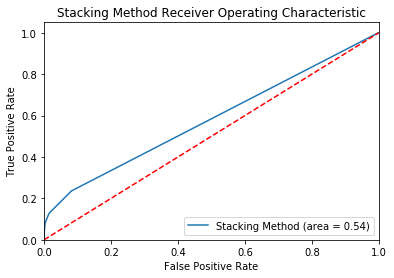

In [91]:
print('Accuracy of Stacking Method on test set: {:.2f}'.format(model_stack.score(S_test, y_test)))
print(classification_report(y_test, y_pred))

logit_roc_auc = roc_auc_score(y_train, model_stack.predict(S_train))
fpr, tpr, thresholds = roc_curve(y_train, model_stack.predict_proba(S_train)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Stacking Method (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Stacking Method Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig('Stack_ROC')
plt.show()

In [92]:
#On balanced data set
S_train_over, S_test_over = stacking(models, X_train_over, y_train_over, X_test_over, regression=False, mode='oof_pred_bag', needs_proba=False,
                          save_dir=None, metric=accuracy_score, n_folds=4, stratified=True, shuffle=True, random_state=123,    
                          verbose=2)

task:         [classification]
n_classes:    [2]
metric:       [accuracy_score]
mode:         [oof_pred_bag]
n_models:     [5]

model  0:     [KNeighborsClassifier]
    fold  0:  [0.68311327]
    fold  1:  [0.69888734]
    fold  2:  [0.68150209]
    fold  3:  [0.69262865]
    ----
    MEAN:     [0.68903284] + [0.00710272]
    FULL:     [0.68903181]

model  1:     [LogisticRegression]
    fold  0:  [0.68172342]
    fold  1:  [0.68219750]
    fold  2:  [0.66689847]
    fold  3:  [0.66133519]
    ----
    MEAN:     [0.67303864] + [0.00913759]
    FULL:     [0.67304015]

model  2:     [DecisionTreeClassifier]
    fold  0:  [0.70396108]
    fold  1:  [0.71279555]
    fold  2:  [0.70097357]
    fold  3:  [0.67454798]
    ----
    MEAN:     [0.69806955] + [0.01425888]
    FULL:     [0.69807057]

model  3:     [AdaBoostClassifier]
    fold  0:  [0.92564281]
    fold  1:  [0.92280946]
    fold  2:  [0.89916551]
    fold  3:  [0.90959666]
    ----
    MEAN:     [0.91430361] + [0.01063302]
    FU

In [93]:
#choose the best model
model = best_forest_model
    
model_stack = model.fit(S_train_over, y_train_over)
y_pred_over = model_stack.predict(S_test_over)

Accuracy of Stacking Method on test set: 0.97
              precision    recall  f1-score   support

           0       0.98      0.95      0.97       752
           1       0.95      0.98      0.96       687

    accuracy                           0.97      1439
   macro avg       0.97      0.97      0.97      1439
weighted avg       0.97      0.97      0.97      1439



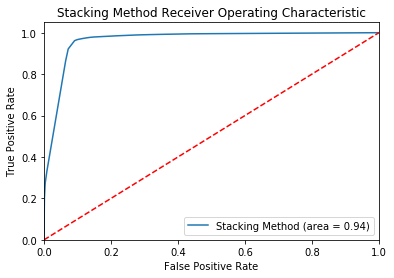

In [94]:
print('Accuracy of Stacking Method on test set: {:.2f}'.format(model_stack.score(S_test_over, y_test_over)))
print(classification_report(y_test_over, y_pred_over))

logit_roc_auc = roc_auc_score(y_train_over, model_stack.predict(S_train_over))
fpr, tpr, thresholds = roc_curve(y_train_over, model_stack.predict_proba(S_train_over)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Stacking Method (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Stacking Method Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig('Stack_ROC')
plt.show()

We can see that stacking greatly improves the accuracy of the balanced data set.

<h3> Comparison of Models <h3>

- Plot an ROC curve comparing all of the models


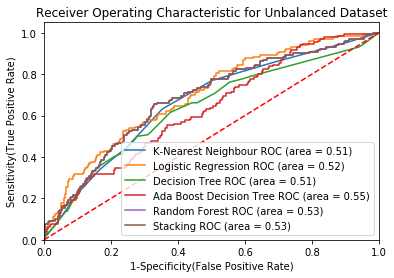

In [95]:
plt.figure()
# Add the models to the list that you want to view on the ROC plot
models = [{'label': 'K-Nearest Neighbour','model': best_KNN_model,},
    {'label': 'Logistic Regression','model': best_logistic_model,},
    {'label': 'Decision Tree','model': best_tree_model,},
    {'label': 'Ada Boost Decision Tree','model': ada_clf,},
    {'label': 'Random Forest','model': best_forest_model,},
    {'label': 'Stacking','model': model_stack,},]

# Below for loop iterates through your models list
for m in models:
    model = m['model'] # select the model
    model.fit(X_train, y_train) # train the model
    y_pred=model.predict(X_test) # predict the test data
# Compute False postive rate, and True positive rate
    fpr, tpr, thresholds = metrics.roc_curve(y_test, model.predict_proba(X_test)[:,1])
# Calculate Area under the curve to display on the plot
    auc = metrics.roc_auc_score(y_test,model.predict(X_test))
# Now, plot the computed values
    plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (m['label'], auc))
# Custom settings for the plot 
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic for Unbalanced Dataset')
plt.legend(loc="lower right")
plt.show()

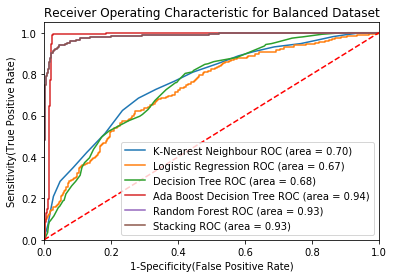

In [96]:
plt.figure()
# Add the models to the list that you want to view on the ROC plot
models = [{'label': 'K-Nearest Neighbour','model': best_KNN_model,},
    {'label': 'Logistic Regression','model': best_logistic_model,},
    {'label': 'Decision Tree','model': best_tree_model,},
    {'label': 'Ada Boost Decision Tree','model': ada_clf,},
    {'label': 'Random Forest','model': best_forest_model,},
    {'label': 'Stacking','model': model,},]

# Below for loop iterates through your models list
for m in models:
    model = m['model'] # select the model
    model.fit(X_train_over, y_train_over) # train the model
    y_pred=model.predict(X_test_over) # predict the test data
# Compute False postive rate, and True positive rate
    fpr, tpr, thresholds = metrics.roc_curve(y_test_over, model.predict_proba(X_test_over)[:,1])
# Calculate Area under the curve to display on the plot
    auc = metrics.roc_auc_score(y_test_over,model.predict(X_test_over))
# Now, plot the computed values
    plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (m['label'], auc))
# Custom settings for the plot 
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic for Balanced Dataset')
plt.legend(loc="lower right")
plt.show()

We can clearly see that Ada Boost Decision Trees, Random Forest and Stacking are the best models.

<h3> Part II: Launch our Model <h3>

In launching our model, our model could be implemented to help healthcare professionals in treatment plan to prevent conditions such as coronary heart disease, by taking into account people's current lifestyle factors, and how they can be altered to change the course of their health.